In [4]:
import pandas as pd
import numpy as np

# Define column names
col_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
            ['sensor_' + str(i) for i in range(1, 22)]

# Load data (after uploading it in Colab)
df = pd.read_csv('train_FD001.txt', sep=' ', header=None)
df.drop([26, 27], axis=1, inplace=True)  # drop empty columns
df.columns = col_names

# Preview
df.head()


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
# Remaining Useful Life (RUL)
rul = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul.columns = ['unit_number', 'max_cycle']
df = df.merge(rul, on='unit_number', how='left')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop('max_cycle', axis=1, inplace=True)

# Normalize sensor readings (Min-Max)
from sklearn.preprocessing import MinMaxScaler

sensor_cols = [col for col in df.columns if 'sensor_' in col]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

df[['unit_number', 'time_in_cycles', 'RUL'] + sensor_cols].head()


,unit_number,time_in_cycles,RUL,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,191,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,...,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662
1,1,2,190,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,...,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014
2,1,3,189,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,...,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375
3,1,4,188,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,...,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386
4,1,5,187,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,...,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502


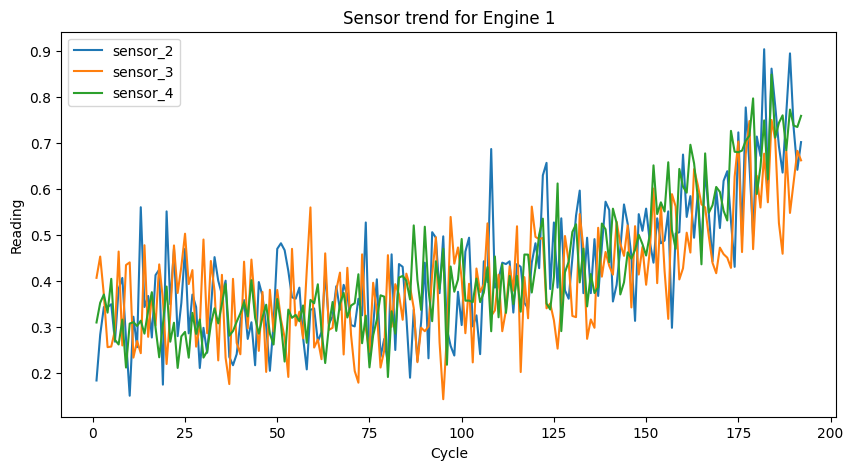

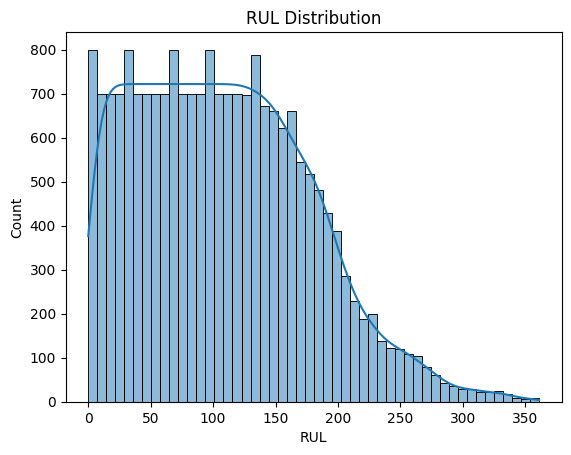

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sensor trend for one engine
engine_id = 1
engine_df = df[df['unit_number'] == engine_id]
plt.figure(figsize=(10,5))
for s in ['sensor_2', 'sensor_3', 'sensor_4']:
    plt.plot(engine_df['time_in_cycles'], engine_df[s], label=s)
plt.title(f'Sensor trend for Engine {engine_id}')
plt.xlabel('Cycle'); plt.ylabel('Reading'); plt.legend()
plt.show()

# Plot RUL distribution
sns.histplot(df['RUL'], bins=50, kde=True)
plt.title('RUL Distribution')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Features & Target
X = df[sensor_cols]
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 43.37


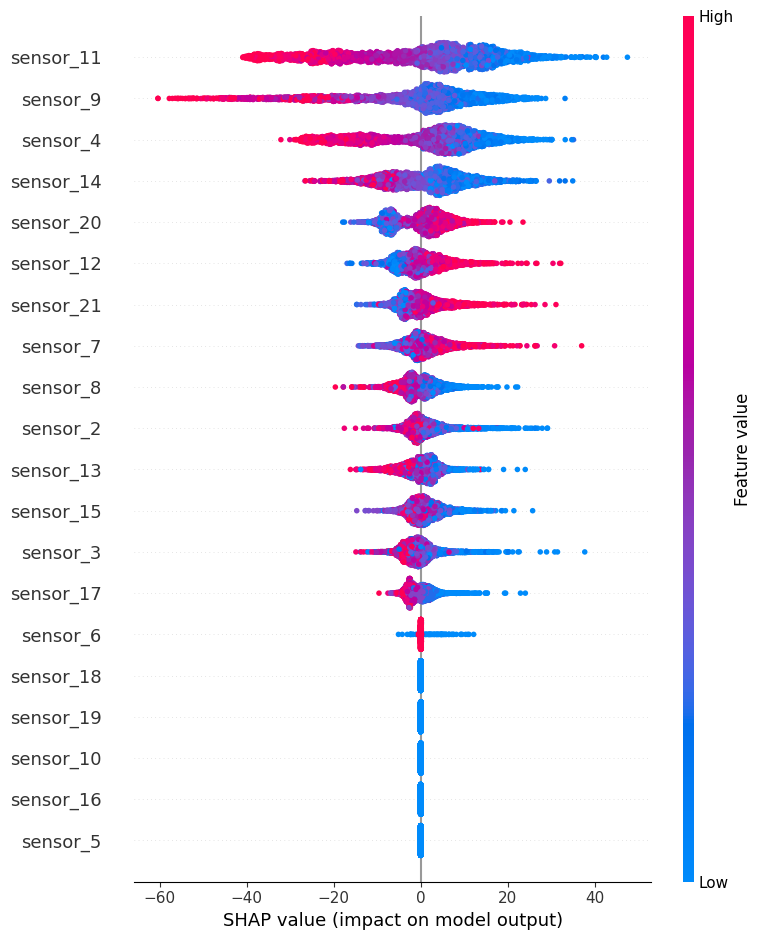

In [9]:
!pip install shap

import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)


In [10]:
!pip install shap


In [11]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values for the test data
shap_values = explainer(X_test)


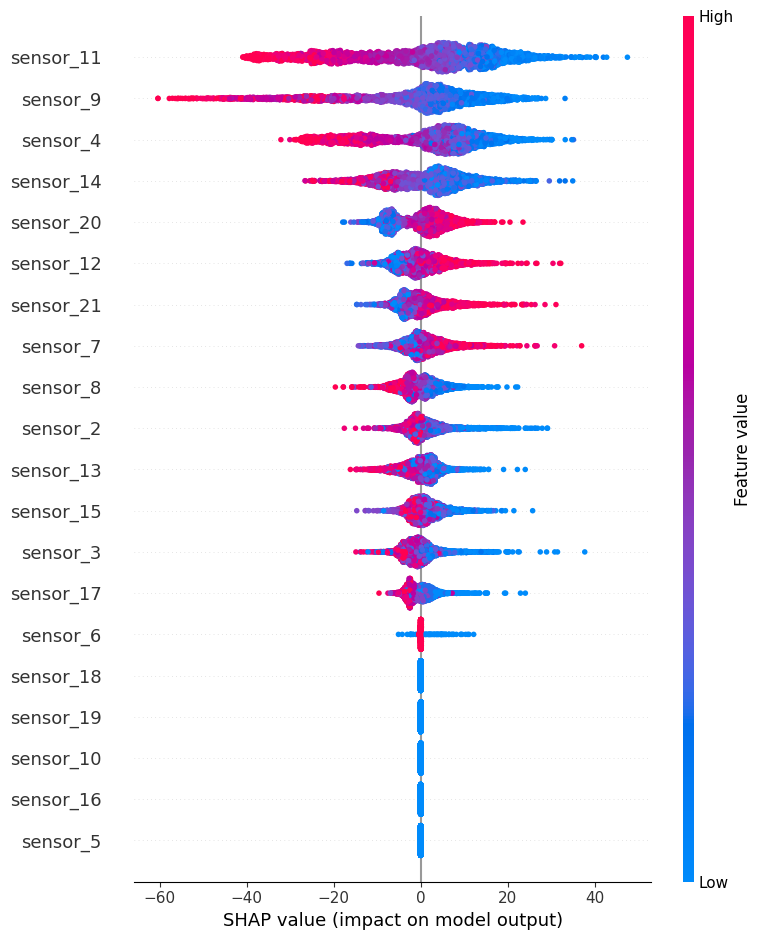

In [12]:
# Summary plot (bar + beeswarm)
shap.summary_plot(shap_values, X_test)


In [16]:
# SHAP Force plot for the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


ValueError: visualize() can only display Explanation objects (or arrays of them)!

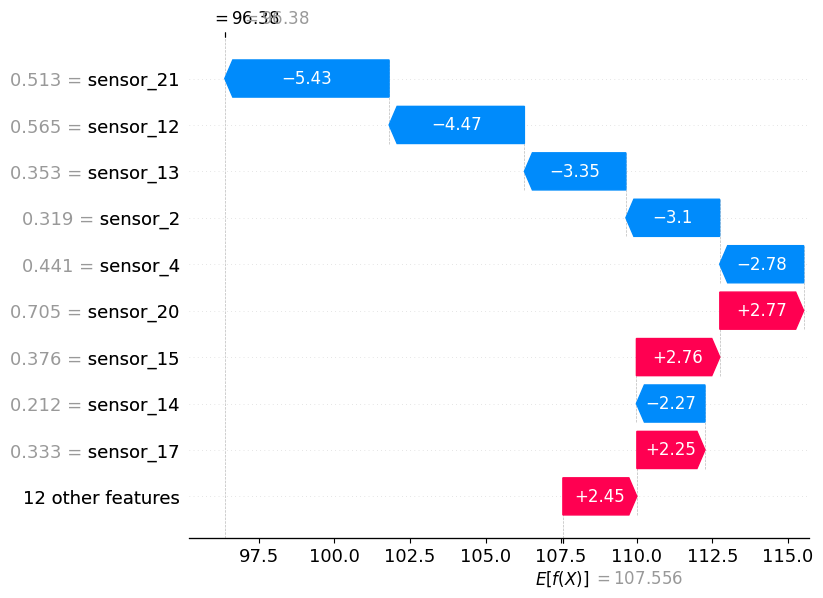

In [15]:
# Waterfall plot for 1st prediction (clean, modern alternative to force plot)
shap.plots.waterfall(shap_values[0])


In [3]:
from google.colab import files
uploaded = files.upload()


Saving train_FD001.txt to train_FD001.txt
